# Кредитный скоринг
При принятии решения о выдаче кредита или займа учитывается т.н. «Кредитный скоринг» — рейтинг платежеспособности клиента. ИИ на основе модели, которую просчитывает машинное обучение — в ней много параметров — возраст, зарплата, кредитная история, наличие недвижимости, автомобиля, судимости и других признаков, после обработки которых выносится положительное или отрицательное решение

In [48]:
# Импортируем библиотеки
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [1]:
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder\
    .master("local[2]")\
    .appName("Lesson_2")\
    .config("spark.executor.instances",2)\
    .config("spark.executor.memory",'2g')\
    .config("spark.executor.cores",1)\
    .getOrCreate()
sc = spark.sparkContext

21/09/01 16:00:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Данные:
[скачать](https://drive.google.com/file/d/1MuAyZiIm3b_r-AgQSj78tsRPqZpvv_2s/view?usp=sharing)

**application_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   CODE_GENDER	Gender	
*   FLAG_OWN_CAR	Is there a car	
*   FLAG_OWN_REALTY	Is there a property	
*   CNT_CHILDREN	Number of children	
*   AMT_INCOME_TOTAL	Annual income	
*   NAME_INCOME_TYPE	Income category	
*   NAME_EDUCATION_TYPE	Education level	
*   NAME_FAMILY_STATUS	Marital status	
*   NAME_HOUSING_TYPE	Way of living	
*   DAYS_BIRTH	Birthday	Count backwards from current day (0), -1 means yesterday
*   DAYS_EMPLOYED	Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
FLAG_MOBIL	Is there a mobile phone	
*   FLAG_WORK_PHONE	Is there a work phone	
*   FLAG_PHONE	Is there a phone	
*   FLAG_EMAIL	Is there an email	
*   OCCUPATION_TYPE	Occupation	
*   CNT_FAM_MEMBERS	Family size	

**credit_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   MONTHS_BALANCE	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
*   STATUS	Status	
   *   0: 1-29 days past due
   *   1: 30-59 days past due 
   *   2: 60-89 days overdue 
   *   3: 90-119 days overdue 
   *   4: 120-149 days overdue 
    *   5: Overdue or bad debts, write-offs for more than 150 days
    *   C: paid off that month X: No loan for the month


## Считываем данные

In [2]:
schema_app_rec = StructType(
    [
        StructField('ID', IntegerType(), True),
        StructField('CODE_GENDER', StringType(), True),
        StructField('FLAG_OWN_CAR', StringType(), True),
        StructField('FLAG_OWN_REALTY', StringType(), True),
        StructField('CNT_CHILDREN', IntegerType(), True),
        StructField('AMT_INCOME_TOTAL', FloatType(), True),
        StructField('NAME_INCOME_TYPE', StringType(), True),
        StructField('NAME_EDUCATION_TYPE', StringType(), True),
        StructField('NAME_FAMILY_STATUS', StringType(), True),
        StructField('NAME_HOUSING_TYPE', StringType(), True),
        StructField('DAYS_BIRTH', IntegerType(), True),
        StructField('DAYS_EMPLOYED', IntegerType(), True),
        StructField('FLAG_MOBIL', IntegerType(), True),
        StructField('FLAG_WORK_PHONE', IntegerType(), True),
        StructField('FLAG_PHONE', IntegerType(), True),
        StructField('FLAG_EMAIL', IntegerType(), True),
        StructField('OCCUPATION_TYPE', StringType(), True),
        StructField('CNT_FAM_MEMBERS', FloatType(), True),
    ]
)

data = spark.read.format('csv').schema(schema_app_rec).option('header', True).load('application_record.csv')
data.printSchema()
#data.registerTempTable('data')
#data.show()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: float (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: float (nullable = true)



In [3]:
schema_cr_rec = StructType(
    [
        StructField('ID', IntegerType(), True),
        StructField('MONTHS_BALANCE', IntegerType(), True),
        StructField('STATUS', StringType(), True),
    ]
)

record = spark.read.format('csv').schema(schema_cr_rec).option('header', True).load('credit_record.csv')
record.printSchema()
#record.registerTempTable('record')
#record.show()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



In [4]:
begin_month = record.groupBy(F.col('ID').alias('ID')).agg((F.min(F.col('MONTHS_BALANCE')) * -1).alias('begin_month'))
new_data = data.join(begin_month, on = 'ID', how = 'left')
#new_data.show()

#def func_status(status):
#    if status == 2 or status == 3 or status == 4 or status == 5:
#        return 1
#    return 0

#func_udf = F.udf(func_status, IntegerType())
#cpunt = record.withColumn('dep_value', func_udf(record['STATUS']))

cpunt = record.withColumn('dep_value', 
    F.when((F.col('STATUS') == 2) | (F.col('STATUS') == 3) | (F.col('STATUS') == 4) | (F.col('STATUS') == 5), 1)
    .otherwise(0))

In [5]:
cpunt.groupBy(F.col('dep_value').alias('dep_value')).agg(F.count('ID')).alias('count').show()

+---------+---------+
|dep_value|count(ID)|
+---------+---------+
|        1|     3104|
|        0|  1045471|
+---------+---------+



In [6]:
cpunt.show()
cpunt.printSchema()

+-------+--------------+------+---------+
|     ID|MONTHS_BALANCE|STATUS|dep_value|
+-------+--------------+------+---------+
|5001711|             0|     X|        0|
|5001711|            -1|     0|        0|
|5001711|            -2|     0|        0|
|5001711|            -3|     0|        0|
|5001712|             0|     C|        0|
|5001712|            -1|     C|        0|
|5001712|            -2|     C|        0|
|5001712|            -3|     C|        0|
|5001712|            -4|     C|        0|
|5001712|            -5|     C|        0|
|5001712|            -6|     C|        0|
|5001712|            -7|     C|        0|
|5001712|            -8|     C|        0|
|5001712|            -9|     0|        0|
|5001712|           -10|     0|        0|
|5001712|           -11|     0|        0|
|5001712|           -12|     0|        0|
|5001712|           -13|     0|        0|
|5001712|           -14|     0|        0|
|5001712|           -15|     0|        0|
+-------+--------------+------+---

In [7]:
cpunt_temp = cpunt.select('ID', 'dep_value')
new_data = new_data.join(cpunt_temp, on = 'ID', how = 'left')
new_data.show()

+-------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+---------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|begin_month|dep_value|
+-------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+---------+
|5008804|          M|           Y|              Y|           0|        427500.0|         Working|   Higher education|    Civil marriage| Rented apartme

In [8]:
dataset = new_data.select('AMT_INCOME_TOTAL', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'dep_value')
dataset = dataset.withColumnRenamed('dep_value', 'target')
dataset.show()

+----------------+-----------+------------+---------------+------------+------+
|AMT_INCOME_TOTAL|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|target|
+----------------+-----------+------------+---------------+------------+------+
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|          

У нас есть выборка, где указаны параметры клиента, и вышел ли он на просрочку или нет.

Дальше будем исследовать, есть ли связь между этими параметрами и возвратом кредита.

Можете уже на этом этапе предложить гипотезы, а мы их проверим. Предположим, что чем больше детей, тем меньше вероятность, что будет просрочка.

In [9]:
(train, test) = dataset.randomSplit([0.7, 0.3], 42)

In [10]:
from pyspark.mllib.stat import Statistics

dataset2 = dataset.select('AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'target')
col_names = dataset2.columns
features = dataset2.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

21/09/01 16:03:44 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/09/01 16:03:44 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [11]:
print(corr_df.to_string())

                  AMT_INCOME_TOTAL  CNT_CHILDREN  target
AMT_INCOME_TOTAL          1.000000      0.031708     NaN
CNT_CHILDREN              0.031708      1.000000     NaN
target                         NaN           NaN     1.0


In [8]:
# Превращаем категориальные факторы в численные
ohe = OneHotEncoder()
ohe.fit(X_train[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])
X_train_ohe = ohe.transform(X_train[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])
X_test_ohe = ohe.transform(X_test[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']])

X_train_ohe = pd.DataFrame(X_train_ohe.toarray(), columns=[item for sublist in ohe.categories_ for item in sublist])
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=[item for sublist in ohe.categories_ for item in sublist])

In [9]:
# Отскалируем численные
mms = MinMaxScaler()
mms.fit(X_train[['AMT_INCOME_TOTAL', 'CNT_CHILDREN']])
X_train_scaled = mms.transform(X_train[['AMT_INCOME_TOTAL', 'CNT_CHILDREN']])
X_test_scaled = mms.transform(X_test[['AMT_INCOME_TOTAL', 'CNT_CHILDREN']])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=['AMT_INCOME_TOTAL', 'CNT_CHILDREN'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['AMT_INCOME_TOTAL', 'CNT_CHILDREN'])

In [10]:
X_train = pd.concat([X_train_scaled, X_train_ohe,], axis=1)
X_test = pd.concat([X_test_scaled, X_test_ohe, ], axis=1)

#  Модель

Модель будет находить коэффициенты alpha и beta, где Х наши колонки/факторы. Данная формула даёт вероятность события.

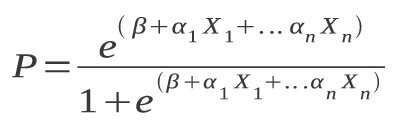

Метрика не совсем корректна для данной задачи (но представим, что нас она устраивает).

In [11]:
# Создадим простейшую модель, которая покажет через линейные коэффиценты связь переменных и таргета
model = LogisticRegression()

In [12]:
# Подберём памраметры
grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}
clf = GridSearchCV(model, grid, scoring='accuracy')
clf.fit(X_train, y_train);

In [13]:
# Проверим результат
train_score = accuracy_score(clf.best_estimator_.predict(X_train), y_train)
test_score = accuracy_score(clf.best_estimator_.predict(X_test), y_test)
print(f'Точность модели на трейне {train_score}, на тесте {test_score}')

Точность модели на трейне 0.9828755045260394, на тесте 0.983635033827025


<AxesSubplot:>

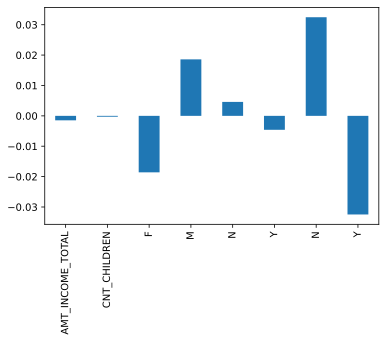

In [14]:
# Посмотрим на коэффиценты
pd.Series(clf.best_estimator_.coef_[0], index=X_train.columns).plot.bar()

Из графика выше видно, какая переменная и с какой силой влияет на скор.

Сильнее всего на просрочку влияет наличие недвижимости. Отсутствие машины или жилья снижает рейтинг.

Наша гипотеза (наличие детей) оказалась неверной (налаичие детей уменьшает риск дефолта, но слабо.